# Second-Order Methods in TensorFlow - Part 2

Now we'd like to actually implement a second-order method.
Here, we implement a very silly version of Newton's method:
one that is attracted to any point where the gradient is $0$.

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

import numpy as np

import second_order

%matplotlib inline

# Minimizing Quadratic Forms with Gradient Descent and Newton's Method

## Testing with Identity Matrix

The identity matrix also makes a good test for the Newton method, since, if we set the `newton_rate`, or the learning rate of the Newton method, to exactly $1$, (and if we turn off Hessian-fudging, to be explained in a second) then we should get convergence in a single step.

The value that minimizes the identity matrix is the same that minimizes any positive definite quadratic form: $\mathbf{0}$, the zero vector.

In [2]:
N = 2

identity_matrix = np.eye(N).astype(np.float32)

initial_values = np.random.standard_normal(size=N).astype(np.float32)

identity_quadratic_form = second_order.make_quadratic_form(identity_matrix, initial_values,
                                                                 second_order.DEFAULTS)

In [3]:
final_output, final_parameters = second_order.minimize(identity_quadratic_form, "newton", 1)

assert final_output == 0
assert np.array_equal(final_parameters, [0,0])

In contrast, gradient descent takes more than one step to even approximately minimize this quadratic form.

In [4]:
final_output, final_parameters = second_order.minimize(identity_quadratic_form, "gradient_descent", 1)

final_output, final_parameters

(2.6930468, array([0.6214015, 1.5188506], dtype=float32))

## Random Positive Definite Matrix

We expect that the Hessians of neural newtorks will behave approximately as if they were drawn from the Wishart distribution, which is generated by taking the outer product of a Gaussian random vector with itself.

The spectra of these matrices should roughly follow the Marçenko-Pastur distribution, which frequently produces eigenvalues that are close to or exactly $0$. These matrices are often quite ill-conditioned.

This is a problem for the Newton method, which relies on inverting the Hessian -- a Hessian with some eigenvalues equal to $0$ is not invertible!
Of course, on a computer, values within $\epsilon$ of $0$ are also non-invertible, for some values of $\epsilon$.

A full-rank Wishart matrix can sometimes be numerically inverted.
Running the cells below will give you a sense of how often this operation fails.

In [5]:
def generate_wishart(N):
    self_outer_product = lambda x: x.dot(x.T)
    wishart_random_matrix = 1/N*self_outer_product(np.random.standard_normal(size=(N,1))).astype(np.float32)
    
    return wishart_random_matrix

In [6]:
N = 5

wishart_random_matrix = generate_wishart(N)

initial_values = np.random.standard_normal(size=N).astype(np.float32)

wishart_quadratic_form = second_order.make_quadratic_form(wishart_random_matrix, initial_values,
                                                                 second_order.DEFAULTS)

In [7]:
try: 
    second_order.minimize(wishart_quadratic_form, "newton", 1)
except tf.errors.InvalidArgumentError:
    hessian = second_order.get_result("hessian", initial_values, wishart_quadratic_form)    
    smallest_eigenvalue = np.min(np.linalg.eigvalsh(hessian))
    print("the newton method failed because")
    print("\t the hessian's smallest eigenvalue is {0}".format(smallest_eigenvalue))
    assert np.isclose(smallest_eigenvalue, 0, atol=1e-05)
    

We have two methods for getting around this.

### Method #1: Fudging

The first method is *fudging*.
Just adding a very small number to the diagonal of the Hessian
adds that small number to all of its eigenvalues (think traces).
The Newton updates are no longer exact, but at least they're not `NaN`s.

We still generically see better performance for one step of the Newton method than one step of gradient descent.

In [8]:
N = 5

wishart_random_matrix = generate_wishart(N)

initial_values = np.random.standard_normal(size=N).astype(np.float32)

wishart_quadratic_form = second_order.make_quadratic_form(wishart_random_matrix, initial_values,
                                                                 {"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "fudge_factor":10e-7,
                                                                 "inverse_method":"fudged"})

In [9]:
second_order.minimize(wishart_quadratic_form, "newton", 1)

(0.00023363973,
 array([-0.46123493, -1.2240683 ,  1.8060265 ,  0.6424237 , -1.3581266 ],
       dtype=float32))

In [10]:
second_order.minimize(wishart_quadratic_form, "gradient_descent", 1)

(0.5547678, array([-0.8783318, -0.4978798,  2.2692933,  0.847288 , -1.1402245],
       dtype=float32))

The two plots below compare a large sequence of runs of gradient descent
and the (fudged) netwon method
on a variety of randomly chosen positive definite, symmetric matrices
across a number of initializations.

In both plots, the results are normalized so that the value of the function
at the inital point is equal to 1.

In [11]:
results = second_order.compare_descent_methods(generate_wishart, N,
                                               num_steps=2, num_matrices=20, num_runs=10,
                                              hyperparameters={"learning_rate":0.1, "newton_rate":1,
                                                               "fudge_factor":1e-6, "inverse_method":"fudged"})

In [12]:
normalized_results = second_order.normalize_runs(results)

The first plot shows the value of the solution across the first two iterations.
From this plot, it is clear that the fudged Newton Method is better in general.

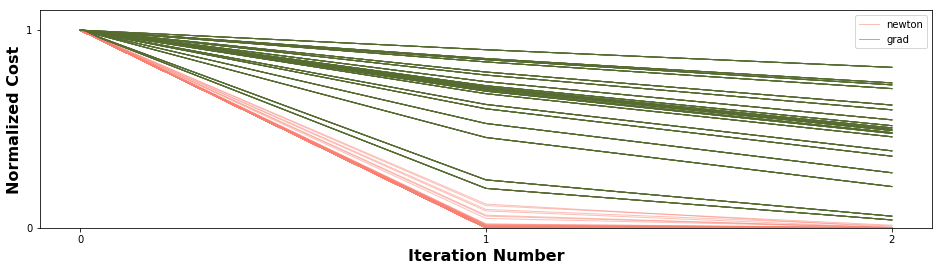

In [13]:
second_order.plot_trajectories_comparison(normalized_results)

The second plot shows the benefit for performance on a more precise basis:
if I start from the exact same point on the exact same function,
what is the difference between the value obtained by gradient descent
and the value obtained by the Newton Method.

The fact that all of the dots are above 0 indicates that Newton Method is a better choice.

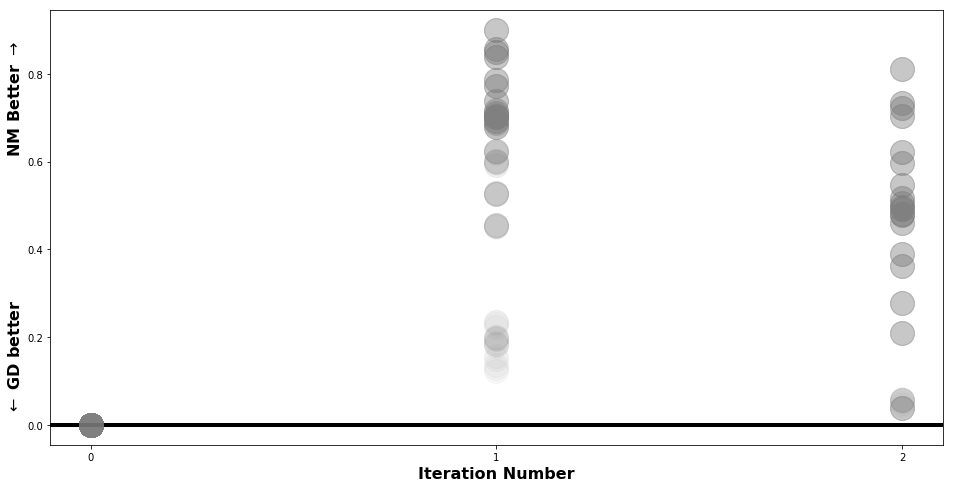

In [14]:
second_order.plot_benefit(normalized_results)

In our work, we aren't as interested in optimization.
Instead, we are trying to find critical points,
places where the gradient norm goes to $0$.

In [15]:
second_order.gradient_test(N=5, matrix_generator=generate_wishart,
                           num_newton_steps=2, hyperparameters={"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "fudge_factor":1e-6,
                                                                 "inverse_method":"fudged"})

output:
	initial: 9.860360145568848 	final: 1.1135489330627024e-07
gradient:
	initial: 9.913769721984863 	final: 0.0010551438899710774


Our Hessians are large -- order one million entries, at the minimum.
We should ensure our method works on large matrices

On `redwood1`, which has around 30 gigabytes of memory,
I can reliably minimize these quadratic forms without memory or numerical error
up to at least `N=5000`,
or 25,000,000 entries in the Hessian.

In [16]:
second_order.gradient_test(N=1000, matrix_generator=generate_wishart, num_newton_steps=2, hyperparameters={"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "fudge_factor":1e-6,
                                                                 "inverse_method":"fudged"})

output:
	initial: 0.3545004725456238 	final: 4.95521817356348e-07
gradient:
	initial: 1.2001668214797974 	final: 0.0014224828919395804


In [17]:
second_order.gradient_test(N=5000, matrix_generator=generate_wishart, num_newton_steps=2, hyperparameters={"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "fudge_factor":1e-6,
                                                                 "inverse_method":"fudged"})

output:
	initial: 0.13861072063446045 	final: 3.229430876672268e-05
gradient:
	initial: 0.7415714859962463 	final: 0.01135181449353695


One issue is that the `newton_rate` parameter is quite finicky:
if it's not within an order of magnitude of the proper value,
it either fails to converge or explodes.

In [18]:
# low newton_rate, progress is sluggish

second_order.gradient_test(N=100, matrix_generator=generate_wishart, num_newton_steps=2,
              hyperparameters={"learning_rate":0.1, "newton_rate":0.1,
                               "fudge_factor":1e-6, "inverse_method":"fudged"})

output:
	initial: 0.7057172656059265 	final: 0.46003857254981995
gradient:
	initial: 1.869313359260559 	final: 1.5092594623565674


In [19]:
# high newton_rate, progress is negative

second_order.gradient_test(N=100, matrix_generator=generate_wishart, num_newton_steps=2,
              hyperparameters={"learning_rate":0.1, "newton_rate":10,
                               "fudge_factor":1e-6, "inverse_method":"fudged"})

output:
	initial: 0.5100390911102295 	final: 2448.52587890625
gradient:
	initial: 1.401347041130066 	final: 97.09487915039062


### Method 2: Pseudo-Inverse

There's another method for handling non-invertible matrices:
just ignoring the parts that are not invertible,
and inverting the rest.

Concretely,
we first compute the eigenvalues and eigenvectors of the Hessian,
and then retain those eigenvalues whose magnitude
is less than some threshold.
We then compute an outer product of those eigenvectors
and scale it by the inverse eigenvalues
to invert the matrix.

That is, we take one formula for the matrix inverse

$$
A^{-1} = \sum_i v_i\lambda_i^{-1}v_i^\intercal
$$

(where each $v_i, \lambda_i$ is a paired eigenvector and eigenvalue)
and simply restrict the sum
to those elements which have eigenvalues sufficiently far from $0$.

This is a method of "pseudo-inversion".
There are several notions of pseudo-inverse.
Our method most closely relates to the Drazin inverse,
but I believe there's a subtle distinction regarding
what exactly is done in the singular eigenspaces.

All of the observations above hold for this method as well
-- including the sensitivity of the `newton_rate` hyperparameter.

In [20]:
N = 5

wishart_random_matrix = generate_wishart(N)

initial_values = np.random.standard_normal(size=N).astype(np.float32)

wishart_quadratic_form = second_order.make_quadratic_form(wishart_random_matrix, initial_values,
                                                                 {"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "minimum_eigenvalue_magnitude":1e-5,
                                                                 "inverse_method":"pseudo"})

In [21]:
second_order.minimize(wishart_quadratic_form, "newton", 1)

(-2.3676552e-08,
 array([ 1.0087099 , -0.24408507, -0.14479013, -0.7951564 ,  0.52372277],
       dtype=float32))

In [22]:
second_order.minimize(wishart_quadratic_form, "gradient_descent", 1)

(0.05639246,
 array([ 1.0836804, -0.2914232, -0.0273832, -0.6749509,  0.5722285],
       dtype=float32))

In [23]:
second_order.gradient_test(5, generate_wishart, 2, {"learning_rate":0.1, "newton_rate":1,
                                       "minimum_eigenvalue_magnitude":1e-5,
                                       "inverse_method":"pseudo"})

output:
	initial: 0.34469127655029297 	final: 1.1600647553677845e-08
gradient:
	initial: 1.5300740003585815 	final: 8.503133130943752e-08


In [24]:
second_order.gradient_test(1000, generate_wishart, 2, {"learning_rate":0.1, "newton_rate":1,
                                       "minimum_eigenvalue_magnitude":1e-5,
                                       "inverse_method":"pseudo"})

output:
	initial: 1.1873184442520142 	final: -9.539533607494377e-08
gradient:
	initial: 2.124858856201172 	final: 2.0818274037992524e-07


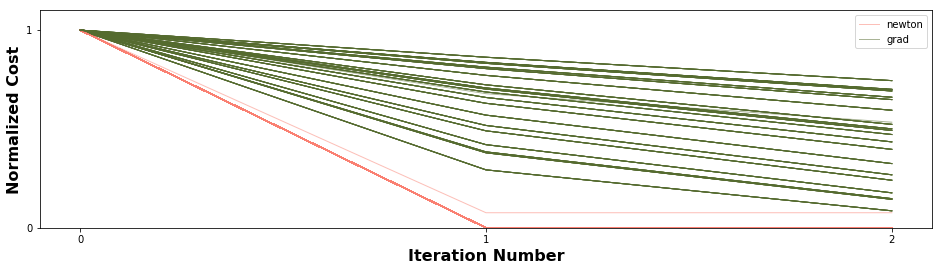

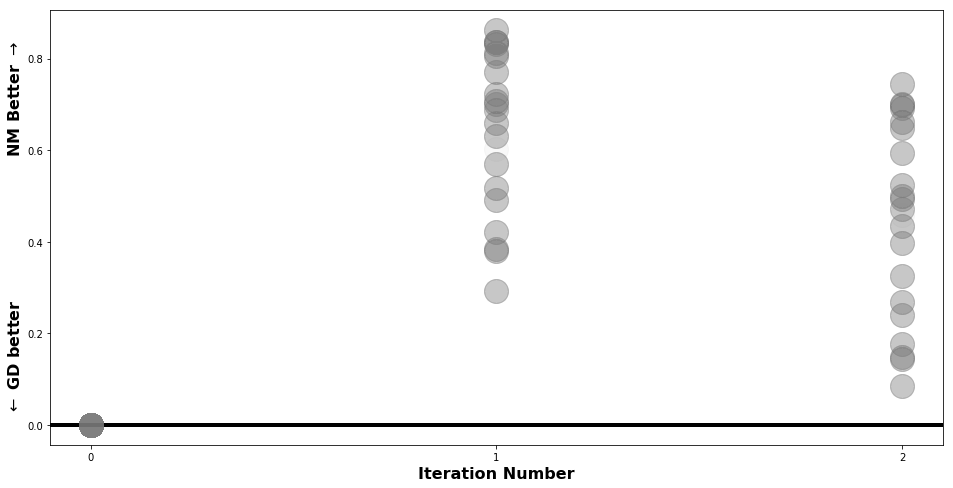

In [25]:
results = second_order.compare_descent_methods(generate_wishart, N,
                                               num_steps=2, num_matrices=20, num_runs=10,
                                              hyperparameters={"learning_rate":0.1, "newton_rate":1,
                                                               "minimum_eigenvalue_magnitude":1e-5,
                                                               "inverse_method":"pseudo"})
normalized_results = second_order.normalize_runs(results)
second_order.plot_trajectories_comparison(normalized_results)
second_order.plot_benefit(normalized_results)

## Random Negative Definite Matrix

The Newton method is designed for convex problems. For problems with directions of negative curvature, it does exactly the opposite of what it should: when the gradient says go down, it actually says go up! This causes it to be attaracted to maxima in this case. For a negative definite quadratic form, this maximum is at $0$.

So if we try to run the Newton method in such a case, we should actually "pessimize", rather than optimize, the function. Gradient descent, even with just one step, will almost surely do better.

For our work, this is a *good thing*, since it means we've found a place where the gradient is close to a $0$: a critical point that is not a minimum (or even a saddle!).

In [26]:
def generate_negative_wishart(N):
    wishart_random_matrix = generate_wishart(N)
    negative_wishart_random_matrix = -1*wishart_random_matrix
    
    return negative_wishart_random_matrix

In [27]:
N = 5

negative_wishart_random_matrix = generate_negative_wishart(N)

initial_values = np.random.standard_normal(size=N)

negative_wishart_quadratic_form = second_order.make_quadratic_form(
                                                    negative_wishart_random_matrix, initial_values,
                                                                 {"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "fudge_factor":10e-7,
                                                                 "inverse_method":"fudged"})

In [28]:
second_order.minimize(negative_wishart_quadratic_form, "newton", 1)

(-0.004706097,
 array([ 0.193196  ,  0.5758843 , -0.10775942, -0.6913018 ,  0.01554906],
       dtype=float32))

In [29]:
second_order.minimize(negative_wishart_quadratic_form, "gradient_descent", 1)

(-1.4526949,
 array([ 0.09391372,  0.5035196 ,  0.6866231 , -0.8568056 , -0.62515485],
       dtype=float32))

In [30]:
second_order.gradient_test(5, generate_negative_wishart, 2, hyperparameters={"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "fudge_factor":10e-7,
                                                                 "inverse_method":"fudged"})

output:
	initial: -0.3416333496570587 	final: -7.735131646313675e-09
gradient:
	initial: 0.9966741800308228 	final: 1.7040274542523548e-06


On a negative definite quadratic form,
our pseudo-method also finds a critical point.

In [31]:
second_order.gradient_test(5, generate_negative_wishart, 2, hyperparameters={"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "minimum_eigenvalue_magnitude":1e-6,
                                                                 "inverse_method":"pseudo"})

output:
	initial: -0.33318179845809937 	final: -9.492216790363273e-09
gradient:
	initial: 1.5797569751739502 	final: 5.735200403478302e-08
